### Librerias

In [5]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))
import pandas as pd
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve, fbeta_score, confusion_matrix, precision_score, recall_score,f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
from src.model_utils import find_best_threshold
import shap

### Carga de datos

In [6]:
final_lgb = joblib.load("../models/final_lightgbm.pkl")
final_xgb = joblib.load("../models/final_xgboost.pkl")
stack = joblib.load("../models/final_stacking.pkl")
vote = joblib.load("../models/final_voting.pkl")

X_test_clean = joblib.load("../models/X_test_clean.pkl")
y_test = pd.read_csv("../data/processed/final_dataset.csv")["target"].iloc[X_test_clean.index] 

models = {
    "LightGBM": final_lgb,
    "XGBoost": final_xgb,
    "Stacking": stack,
    "Voting": vote,
}

### Resultados


📊 LightGBM — Threshold = 0.251 — F2 = 0.682 — ROC AUC = 0.775
              precision    recall  f1-score   support

           0      0.982     0.448     0.615       375
           1      0.312     0.969     0.472        97

    accuracy                          0.555       472
   macro avg      0.647     0.709     0.544       472
weighted avg      0.845     0.555     0.586       472



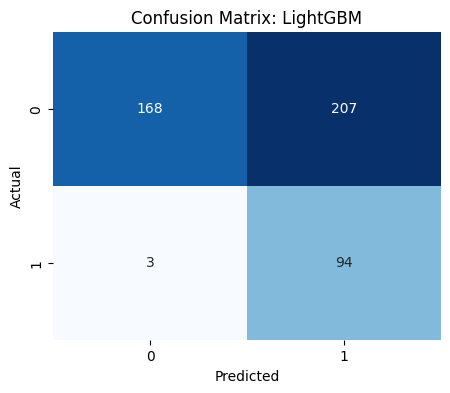


📊 XGBoost — Threshold = 0.35899999737739563 — F2 = 0.676 — ROC AUC = 0.769
              precision    recall  f1-score   support

           0      0.968     0.483     0.644       375
           1      0.319     0.938     0.476        97

    accuracy                          0.576       472
   macro avg      0.644     0.710     0.560       472
weighted avg      0.835     0.576     0.610       472



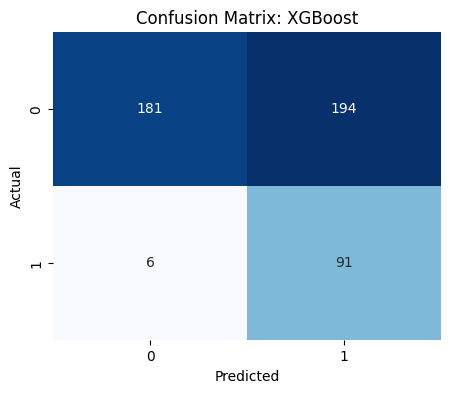


📊 Stacking — Threshold = 0.15 — F2 = 0.674 — ROC AUC = 0.745
              precision    recall  f1-score   support

           0      0.964     0.493     0.653       375
           1      0.321     0.928     0.477        97

    accuracy                          0.583       472
   macro avg      0.642     0.711     0.565       472
weighted avg      0.832     0.583     0.617       472



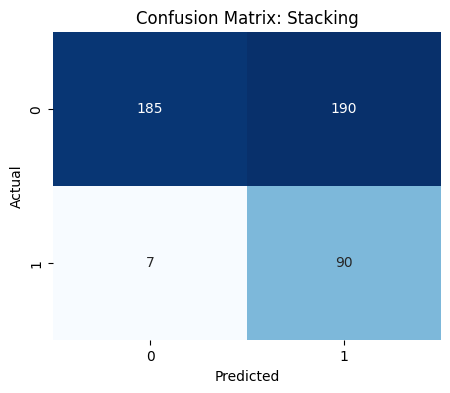


📊 Voting — Threshold = 0.316 — F2 = 0.677 — ROC AUC = 0.771
              precision    recall  f1-score   support

           0      0.968     0.485     0.647       375
           1      0.320     0.938     0.478        97

    accuracy                          0.578       472
   macro avg      0.644     0.712     0.562       472
weighted avg      0.835     0.578     0.612       472



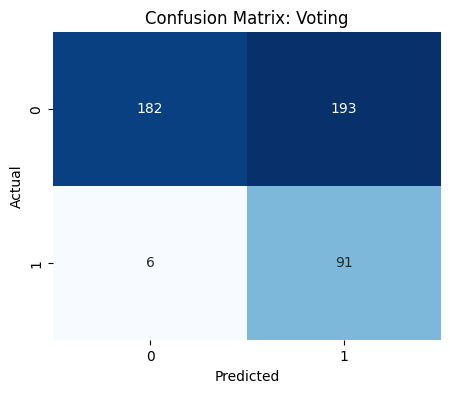


✅ Comparativa de modelos:


,model,threshold,f2,roc_auc
0,LightGBM,0.251,0.682,0.775
1,Voting,0.316,0.677,0.771
2,XGBoost,0.359,0.676,0.769
3,Stacking,0.150,0.674,0.745


In [7]:
results_df = pd.DataFrame(columns=["model", "threshold", "f2", "roc_auc"])

for name, model in models.items():
    y_prob = model.predict_proba(X_test_clean)[:, 1]
    thresh, f2 = find_best_threshold(y_test, y_prob, beta=2.0)
    y_pred = (y_prob >= thresh).astype(int)
    roc_auc = roc_auc_score(y_test, y_prob)


    print(f"\n📊 {name} — Threshold = {round(thresh, 3)} — F2 = {round(f2, 3)} — ROC AUC = {round(roc_auc, 3)}")
    print(classification_report(y_test, y_pred, digits=3))


    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    results_df = pd.concat([results_df, pd.DataFrame([{
        "model": name,
        "threshold": round(thresh, 3),
        "f2": round(f2, 3),
        "roc_auc": round(roc_auc, 3)
    }])], ignore_index=True)


print("\n✅ Comparativa de modelos:")
display(results_df.sort_values("f2", ascending=False).reset_index(drop=True))

### Análisis SHAP


📈 SHAP values para XGBoost


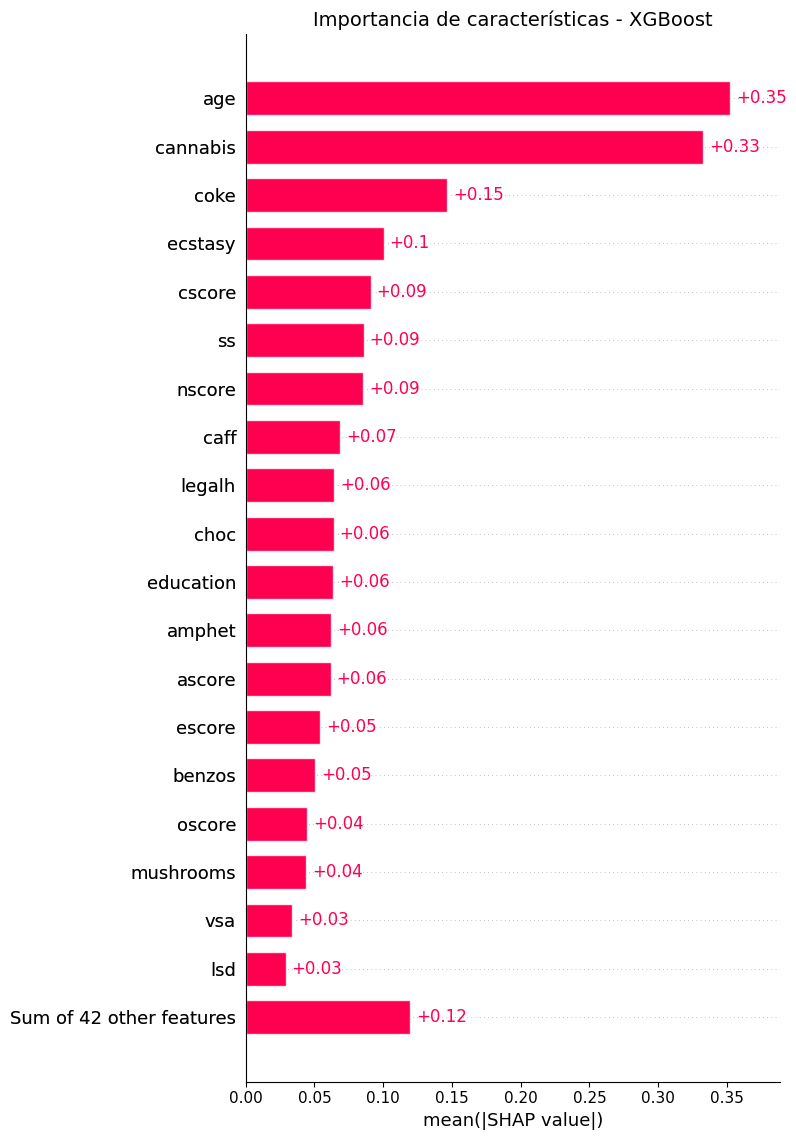

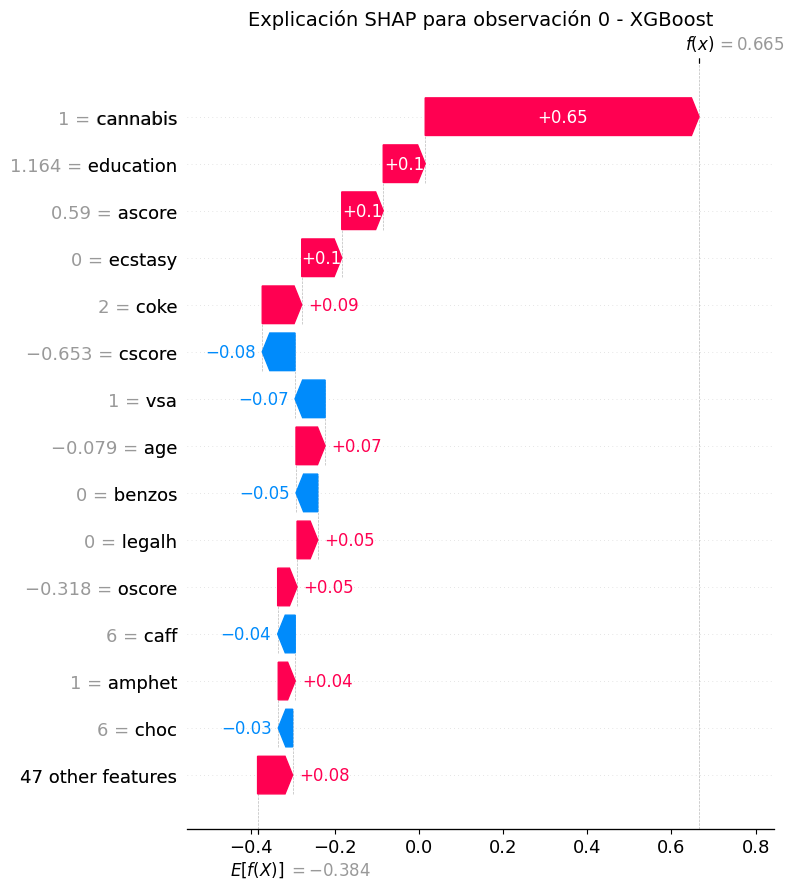


📈 SHAP values para LightGBM


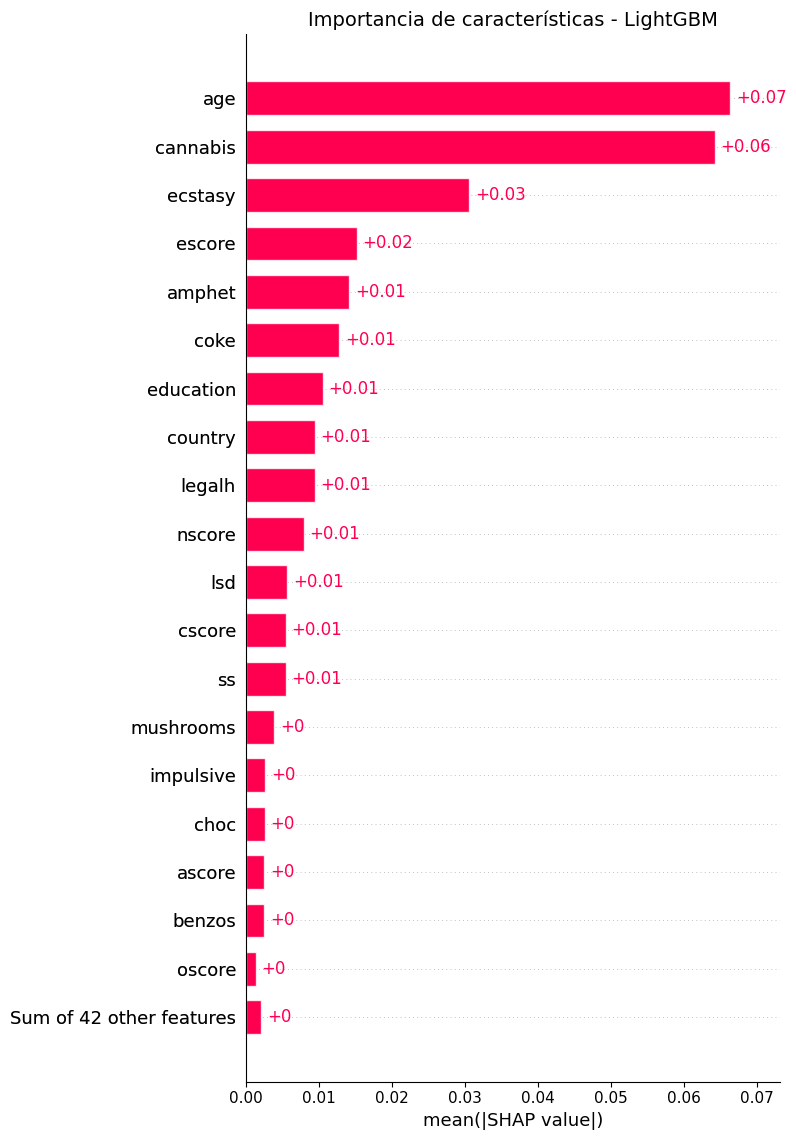

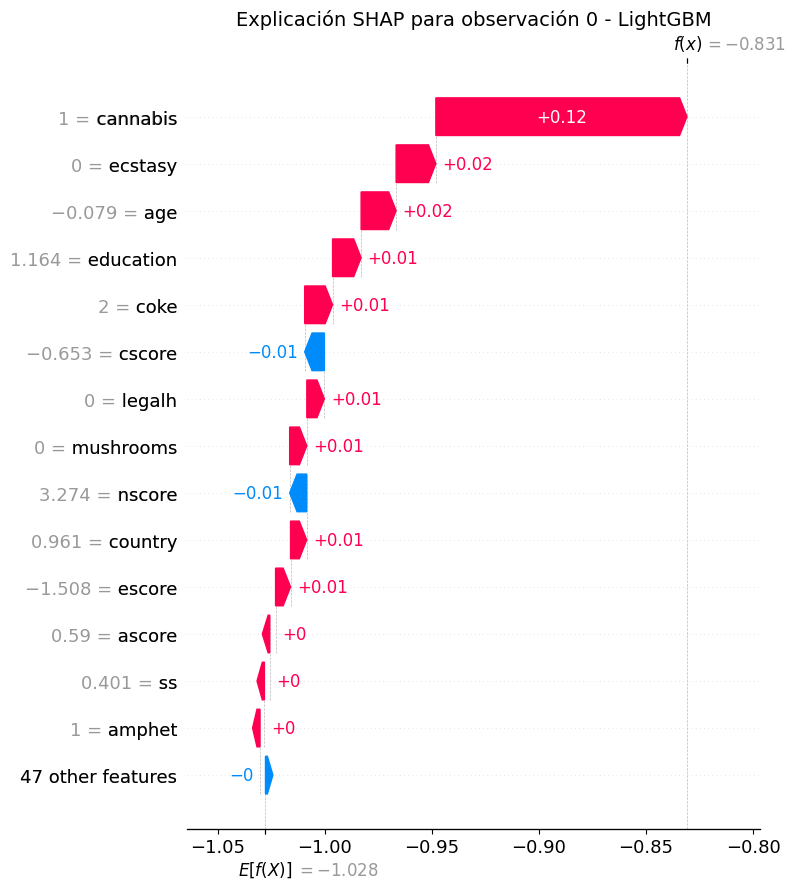

In [9]:
tree_models = {
    "XGBoost": final_xgb,
    "LightGBM": final_lgb
}

for name, model in tree_models.items():
    print(f"\n📈 SHAP values para {name}")
    
    explainer = shap.Explainer(model, X_test_clean)
    shap_values = explainer(X_test_clean)
    
    plt.figure(figsize=(10, 6))
    shap.plots.bar(shap_values, max_display=20, show=False)
    plt.title(f'Importancia de características - {name}', fontsize=14)
    plt.tight_layout()
    plt.show()

    

    obs_idx = 0 
    plt.figure(figsize=(12, 6))
    shap.plots.waterfall(shap_values[obs_idx], max_display=15, show=False)
    plt.title(f'Explicación SHAP para observación {obs_idx} - {name}', fontsize=14)
    plt.tight_layout()
    plt.show()